This notebook has been designed for the nurse care activity recognition challenge competition with the the aim of providing the basic knowledge of Human Activity Recognition by accelerometer.

It has been made by Le Nhat Tan.

# Exploring the data

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline  

First, we have to load the data and label file. In this tutorial, we only use the train data of 1 user to reduce the time of the whole process.

In [3]:
#Load data
df=pd.read_csv('acc_user2.csv')
df_label=pd.read_csv('label/label_train.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'acc_user2.csv'

Let's check what information the data contains.

In [45]:
df.head(5)

,subject_id,datetime,x,y,z
0,2,2018-06-11T10:45:39.643+0900,-1.723,0.651,9.625
1,2,2018-06-01T10:59:22.466+0900,-2.260,0.996,9.471
2,2,2018-06-07T17:20:35.638+0900,1.685,1.800,9.489
3,2,2018-06-11T17:31:06.863+0900,-1.762,-2.068,9.436
4,2,2018-06-19T10:11:05.374+0900,2.834,-8.849,0.001


We can see that the data file contains 5 columns: subject_id, datetime, and 3 coordinates of the accelerometer data.

In [46]:
df_label.head(5)

,id,user_id,activity_type_id,activity_type,target_id,activity2user_id,start,finish
0,2098,38,26,休憩,2,19790,NaN,NaN
1,2852,5,26,休憩,5,21912,NaN,2018-03-15 03:41:24 +0900
2,5487,25,26,休憩,25,28937,NaN,2018-04-12 22:29:33 +0900
3,8872,26,26,休憩,26,37322,NaN,2018-04-26 13:52:11 +0900
4,9672,26,26,休憩,26,39599,NaN,2018-05-01 13:58:43 +0900


For label file, we have 8 columns: id (label id), user_id, activity_type_id, activity_type (name), target_id (patients), activity2user_id, start and finish timestamp of the activity.


Visualization the data

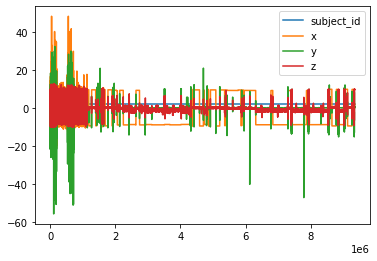

In [47]:
df.plot()

Check the bar plot of labels

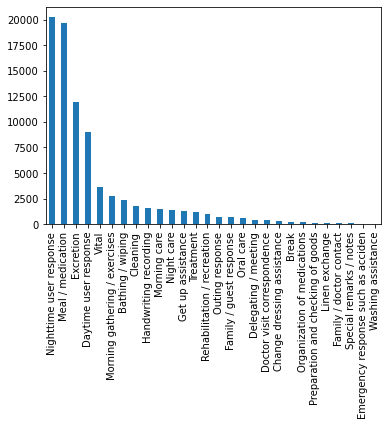

In [4]:
activity_map = {
1: "Vital", 
2: "Meal / medication", 
3: "Oral care", 
4: "Excretion", 
5: "Bathing / wiping",
6: "Treatment", 
7: "Morning gathering / exercises", 
8: "Rehabilitation / recreation", 
9: "Morning care", 
10: "Daytime user response", 
11: "Night care", 
12: "Nighttime user response", 
13: "Family / guest response", 
14: "Outing response", 
19: "Get up assistance", 
20: "Change dressing assistance", 
21: "Washing assistance", 
27: "Emergency response such as acciden",
15: "Linen exchange", 
16: "Cleaning",
23: "Preparation and checking of goods", 
24: "Organization of medications",
17: "Handwriting recording", 
18: "Delegating / meeting", 
22: "Doctor visit correspondence", 
25: "Family / doctor contact",
26: "Break", 
28: "Special remarks / notes"
}

df_label["activity_type_e"]=df_label["activity_type_id"].map(activity_map)
df_label['activity_type_e'].value_counts().plot.bar()

# Pre-processing the data

The missing value and duplicated value rows are dropped. But we can also use several methods to handle missing value, it depends on your pipelines.

All the values are sorted by datetime

In [48]:
df = df.dropna()
df = df.sort_values('datetime')
df = df.drop_duplicates()

In the label file, nan and duplicated value rows are also dropped.

In [50]:
df_label = df_label.drop_duplicates('id')
df_label = df_label.dropna()

Now, we only get the label of user we utilize

In [51]:
df_label_user=df_label[df_label['user_id']==df['subject_id'].sample(1).values[0]]

We change all the timestamp data into the same data type

In [ ]:
df['datetime']= pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S.%f%z')
df_label_user['start'] = pd.to_datetime(df_label_user['start'], format='%Y-%m-%d %H:%M:%S %z')
df_label_user['finish'] = pd.to_datetime(df_label_user['finish'], format='%Y-%m-%d %H:%M:%S %z')

We can check how the data change after pre-processing

In [53]:
df.head(5)

,subject_id,datetime,x,y,z
1054607,2,2018-05-31 08:26:31.126000+09:00,-9.423,0.076,0.227
1894989,2,2018-05-31 08:26:31.326000+09:00,-9.462,0.000,0.227
1065508,2,2018-05-31 08:26:31.526000+09:00,-9.347,0.076,0.227
1066550,2,2018-05-31 08:26:31.533000+09:00,-9.347,0.076,0.227
5875832,2,2018-05-31 08:26:31.726000+09:00,-9.385,0.076,0.235


In [54]:
df_label_user.head(5)

,id,user_id,activity_type_id,activity_type,target_id,activity2user_id,start,finish
47,4375,2,26,休憩,2,26018,2018-04-05 08:38:38+09:00,2018-04-05 08:38:39+09:00
362,5960,2,6,処置,29,30128,2018-04-14 14:47:41+09:00,2018-04-14 14:47:42+09:00
4006,9704,2,4,排泄,81,39664,2018-05-01 17:03:26+09:00,2018-05-01 17:03:50+09:00
4361,11412,2,4,排泄,31,43065,2018-05-04 18:29:20+09:00,2018-05-04 18:29:54+09:00
6394,19144,2,4,排泄,36,58459,2018-05-17 18:00:50+09:00,2018-05-17 18:02:48+09:00


# Segmentation

We try to reset the index value

In [55]:
df_label_user=df_label_user.reset_index()
df_label_user=df_label_user.drop(columns='index')

In [ ]:
df_label_user.head(5)

Segment the data by the timestamp given by label file.

Every segment windows are extracted by the start and finish time of the activity in label file.

In [64]:
seg_list = []
seg_label_list = []

for i in range(len(df_label_user)):
    
    seg = df[(df["datetime"] >=df_label_user['start'][i]) & (df["datetime"] <= df_label_user['finish'][i])]
    seg_label = df_label_user["activity_type_id"][i]
    if (len(seg)!=0):
        seg_list.append(seg)
        seg_label_list.append(seg_label)

# Features Extraction

In this tutorial, we extract 4 main features: STD, Average, Max, Min of 3 coordinates.

In [70]:
def get_features(x_data):
    #Set features list
    features = []
    #Set columns name list
    DFclist=list(x_data.columns)

    #Calculate features (STD, Average, Max, Min) for each data columns X Y Z 
    for k in DFclist:
        # std
        features.append(x_data[k].std(ddof=0))
        # avg
        features.append(np.average(x_data[k]))
        # max
        features.append(np.max(x_data[k]))
        # min
        features.append(np.min(x_data[k]))
    return features

In [73]:
features_list = []
for i in seg_list:
  #Drop 2 columns 'subject_id' and 'datetime', we only use 3 columns x, y, z
  i = i.drop(columns=['subject_id','datetime'])
  features_list.append(get_features(i))

# Training

The Random Forest Model is utilized in this tutorial

In [74]:
from sklearn.ensemble import RandomForestClassifier         
model_ml = RandomForestClassifier(n_estimators=500,n_jobs=-1)

Divide data into train and test file to evaluate the results

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_list, seg_label_list, test_size=0.3, random_state=42)

Train the model

In [76]:
model_ml.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Check the results

In [78]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_predict = model_ml.predict(X_test)
print(classification_report(y_test,y_predict))
confusion_matrix(y_test, y_predict)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           4       0.60      0.33      0.43         9
           7       1.00      0.50      0.67         2
          10       0.42      0.71      0.53         7
          13       0.00      0.00      0.00         1

    accuracy                           0.47        19
   macro avg       0.40      0.31      0.32        19
weighted avg       0.54      0.47      0.47        19



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 0, 0, 0, 0],
       [0, 3, 0, 6, 0],
       [1, 0, 1, 0, 0],
       [0, 2, 0, 5, 0],
       [0, 0, 0, 1, 0]])

Now, your turn!
Let's analyze the challenge dataset!